In [1]:
import pandas as pd
import numpy as np
import os

def filter_and_undersample(
    resmat: pd.DataFrame, 
    min_threshold: int, 
    output_dir: str = "data"
) -> pd.DataFrame:
    """
    Filters scenarios by a minimum size and then undersamples the rest to be balanced.

    Args:
        resmat (pd.DataFrame): The original, imbalanced response matrix.
        min_threshold (int): The minimum number of items a scenario must have to be included.
        output_dir (str): The directory where the output file will be saved.

    Returns:
        pd.DataFrame: A new DataFrame with filtered and balanced scenarios.
    """
    print("--- Starting Filtering and Undersampling Process ---")
    
    # 1. Get original scenario counts
    scenario_labels = resmat.columns.get_level_values('scenario')
    scenario_counts = scenario_labels.value_counts()
    
    # 2. First, filter out any scenarios that are smaller than the threshold
    scenarios_to_process = scenario_counts[scenario_counts >= min_threshold]
    
    if len(scenarios_to_process) < 2:
        print(f"Warning: Less than two scenarios meet the threshold of {min_threshold}. Cannot create a balanced dataset.")
        return pd.DataFrame()
        
    print(f"Kept {len(scenarios_to_process)} scenarios with at least {min_threshold} items.")
    
    # 3. From the REMAINING scenarios, find the new minimum size to use for sampling
    target_sample_size = scenarios_to_process.min()
    print(f"All kept scenarios will be undersampled to {target_sample_size} items.")

    # 4. Loop through the filtered scenarios and sample them to the new target size
    balanced_cols = []
    np.random.seed(42)  # for reproducibility
    for scenario in scenarios_to_process.index:
        scenario_col_indices = np.where(scenario_labels == scenario)[0]
        sampled_indices = np.random.choice(
            scenario_col_indices, size=target_sample_size, replace=False
        )
        balanced_cols.extend(sampled_indices)

    # 5. Create the new, balanced DataFrame
    resmat_balanced = resmat.iloc[:, sorted(balanced_cols)]
    print(f"New balanced matrix shape: {resmat_balanced.shape}")
    
    # 6. Remove models (rows) that have no responses after undersampling
    responses_per_model = resmat_balanced.notna().sum(axis=1)
    models_with_responses = responses_per_model > 0
    empty_models_count = (~models_with_responses).sum()
    
    if empty_models_count > 0:
        print(f"Warning: {empty_models_count} models have no responses after undersampling.")
        print(f"Removing these empty models to ensure calibration condition is met.")
        resmat_balanced = resmat_balanced[models_with_responses]
        print(f"Final matrix shape after removing empty models: {resmat_balanced.shape}")
    else:
        print("✅ All models have at least one response.")
    
    # Verify calibration condition
    final_rows_check = (resmat_balanced.notna().sum(axis=1) > 0).all()
    final_cols_check = (resmat_balanced.notna().sum(axis=0) > 0).all()
    calibration_valid = final_rows_check and final_cols_check
    print(f"Calibration condition check: {'✅ PASS' if calibration_valid else '❌ FAIL'}")
    
    if not calibration_valid:
        print("Warning: Dataset still fails calibration condition!")

    # 7. Save the new DataFrame to a pickle file
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    output_filename = f"resmat_{min_threshold}.pkl"
    full_path = os.path.join(output_dir, output_filename)
    resmat_balanced.to_pickle(full_path)
    print(f"Saved balanced DataFrame to: '{full_path}'")
    print("--------------------------------------------------")
    
    return resmat_balanced

In [2]:
# --- Step 1: Load Data and Print Original Counts ---
print("Loading response matrix...")
resmat = pd.read_pickle("../data/resmat.pkl")

print("\n--- Original Scenario Counts ---")
scenario_counts = resmat.columns.get_level_values('scenario').value_counts()
print(scenario_counts)
print("--------------------------------")

# --- Step 2: Perform Filtering and Undersampling ---
# Use the new function. For example, require at least 500 items per scenario.
resmat_balanced = filter_and_undersample(resmat, min_threshold=2000, output_dir="../data")

if resmat_balanced.empty:
    raise ValueError("Undersampling resulted in an empty DataFrame. Try a smaller min_threshold.")

# The rest of your script for train/test split, SVD, and evaluation follows...

Loading response matrix...

--- Original Scenario Counts ---
scenario
civil_comments                 29407
mmlu                           13223
wikifact                        5511
air_bench_2024                  4985
imdb                            3530
babi_qa                         3461
boolq                           3316
synthetic_reasoning             2234
legalbench                      1997
truthful_qa                     1888
entity_matching                 1396
raft                            1336
bbq                              999
med_qa                           998
gsm                              997
legal_support                    594
thai_exam                        557
dyck_language_np=3               500
commonsense                      498
lsat_qa                          454
math                             436
entity_data_imputation           395
blimp                              0
bold                               0
code                               0
copyr

Loading response matrix...
Training set size (80%): 910536
Test set size (20%): 227634

Starting iteration to find the best rank (k)...
  k= 2, Global AUC = 0.8308
  k= 3, Global AUC = 0.8569
  k= 4, Global AUC = 0.8759
  k= 5, Global AUC = 0.8797
  k= 6, Global AUC = 0.8872
  k= 7, Global AUC = 0.8884
  k= 8, Global AUC = 0.8913
  k= 9, Global AUC = 0.8911
  k=10, Global AUC = 0.8882
  k=11, Global AUC = 0.8876
  k=12, Global AUC = 0.8854
  k=13, Global AUC = 0.8830
  k=14, Global AUC = 0.8813
  k=15, Global AUC = 0.8770
  k=16, Global AUC = 0.8724
  k=17, Global AUC = 0.8680
  k=18, Global AUC = 0.8631
  k=19, Global AUC = 0.8589
  k=20, Global AUC = 0.8563
  k=21, Global AUC = 0.8512
  k=22, Global AUC = 0.8478
  k=23, Global AUC = 0.8409
  k=24, Global AUC = 0.8384
  k=25, Global AUC = 0.8313
  k=26, Global AUC = 0.8268
  k=27, Global AUC = 0.8240
  k=28, Global AUC = 0.8180
  k=29, Global AUC = 0.8198
  k=30, Global AUC = 0.8123

Iteration complete.

--- Optimal Rank Results ---
T

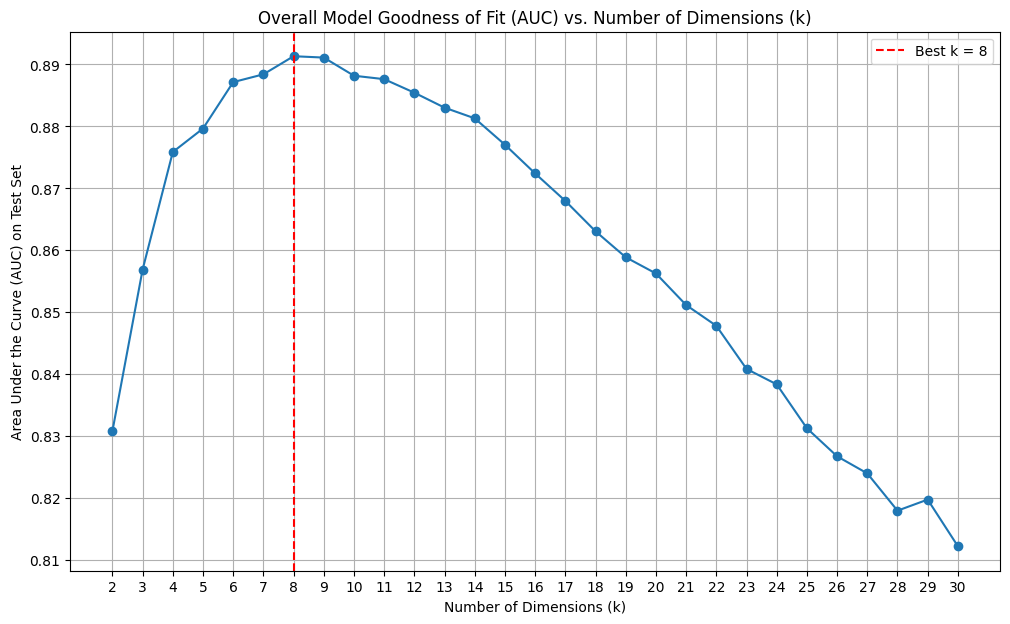


Training final model with optimal k=8 for stratified evaluation...

--- AUC Performance by Scenario ---
              scenario       auc  test_samples
0                 mmlu  0.892254         35405
1       air_bench_2024  0.882993         18200
2             wikifact  0.867131         29939
3                boolq  0.867044         29547
4       civil_comments  0.863077         29939
5  synthetic_reasoning  0.855833         30740
6                 imdb  0.853884         22723
7              babi_qa  0.798757         31141


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ===================================================================
# == Step 1: Load Data and Create a One-Time Train/Test Split
# ===================================================================
print("Loading response matrix...")
# Note: Ensure the path to your data file is correct.
resmat = pd.read_pickle("../data/resmat_2000.pkl")

# Find the locations (row, col indices) of all non-missing values
non_nan_indices = np.argwhere(resmat.notna().values)

# Randomly shuffle these indices
np.random.seed(42)  # for reproducibility
np.random.shuffle(non_nan_indices)

# Decide on the split size
test_size = int(len(non_nan_indices) * 0.20)
test_indices = non_nan_indices[:test_size]
train_indices = non_nan_indices[test_size:]

# Create the training matrix: start with a copy and hide the test data
train_resmat = resmat.copy()
test_rows, test_cols = test_indices[:, 0], test_indices[:, 1]
train_resmat.values[test_rows, test_cols] = np.nan

print(f"Training set size (80%): {len(train_indices)}")
print(f"Test set size (20%): {len(test_indices)}")

# Prepare the data needed for evaluation (do this once)
true_test_values = resmat.values[test_rows, test_cols]
# Using fillna(0) as in your script. Another option is the mean.
imputed_train_resmat = train_resmat.fillna(0)

# ===================================================================
# == Step 2: Iterate Through Dimensions and Calculate Global AUC
# ===================================================================
results = []
rank_range = range(2, 31) # Iterate from k=2 to k=30

print("\nStarting iteration to find the best rank (k)...")
for k in rank_range:
    svd = TruncatedSVD(n_components=k, random_state=42)
    transformed_data = svd.fit_transform(imputed_train_resmat)
    prediction_matrix = svd.inverse_transform(transformed_data)
    predicted_test_values = prediction_matrix[test_rows, test_cols]
    
    # Ensure there are both 0s and 1s in the true values to calculate AUC
    if len(np.unique(true_test_values)) > 1:
        auc_score = roc_auc_score(true_test_values, predicted_test_values)
        results.append({'k': k, 'auc': auc_score})
        print(f"  k={k:2d}, Global AUC = {auc_score:.4f}")

print("\nIteration complete.")

# ===================================================================
# == Step 3: Find and Display the Best Overall Result
# ===================================================================
results_df = pd.DataFrame(results)
best_k_row = results_df.loc[results_df['auc'].idxmax()]
OPTIMAL_K = int(best_k_row['k'])

print("\n--- Optimal Rank Results ---")
print(f"The best performing model has k = {OPTIMAL_K} with a Global AUC of {best_k_row['auc']:.4f}")

# ===================================================================
# == Step 4: Plot the Overall Results
# ===================================================================
plt.figure(figsize=(12, 7))
plt.plot(results_df['k'], results_df['auc'], marker='o', linestyle='-')
plt.axvline(x=OPTIMAL_K, color='r', linestyle='--', label=f'Best k = {OPTIMAL_K}')
plt.title('Overall Model Goodness of Fit (AUC) vs. Number of Dimensions (k)')
plt.xlabel('Number of Dimensions (k)')
plt.ylabel('Area Under the Curve (AUC) on Test Set')
plt.grid(True)
plt.legend()
plt.xticks(rank_range)
plt.show()

# ===================================================================
# == Step 5: Perform Stratified Evaluation with the Best Model
# ===================================================================
print(f"\nTraining final model with optimal k={OPTIMAL_K} for stratified evaluation...")
final_svd = TruncatedSVD(n_components=OPTIMAL_K, random_state=42)
final_svd.fit(imputed_train_resmat)
prediction_matrix_final = final_svd.inverse_transform(final_svd.transform(imputed_train_resmat))

print("\n--- AUC Performance by Scenario ---")
# Get the scenario label for every column in the matrix
scenario_labels = resmat.columns.get_level_values('scenario')
unique_scenarios = scenario_labels.unique()

stratified_results = []

# Loop through each unique scenario
for scenario in unique_scenarios:
    # Find column indices that match the current scenario
    scenario_col_indices = np.where(scenario_labels == scenario)[0]
    
    # Find which test samples belong to this scenario
    is_in_scenario = np.isin(test_indices[:, 1], scenario_col_indices)
    scenario_test_indices = test_indices[is_in_scenario]
    
    if len(scenario_test_indices) < 10: # Skip if too few test samples
        continue

    # Get true and predicted values for this scenario's test set
    s_test_rows, s_test_cols = scenario_test_indices[:, 0], scenario_test_indices[:, 1]
    s_true_values = resmat.values[s_test_rows, s_test_cols]
    s_predicted_values = prediction_matrix_final[s_test_rows, s_test_cols]
    
    # Check if there's more than one class (0s and 1s) to calculate AUC
    if len(np.unique(s_true_values)) > 1:
        auc = roc_auc_score(s_true_values, s_predicted_values)
        stratified_results.append({'scenario': scenario, 'auc': auc, 'test_samples': len(s_true_values)})

# Display the stratified results in a clean DataFrame
stratified_df = pd.DataFrame(stratified_results).sort_values(by='auc', ascending=False).reset_index(drop=True)
print(stratified_df)

# Dimensional Reduction, train on fixed k

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# ===================================================================
# == Step 1: Train the Final SVD Model with Optimal k=11
# ===================================================================
print("Loading and preparing data...")
resmat = pd.read_pickle("../data/resmat_2000.pkl")

imputed_resmat = resmat.fillna(0)

# Train the final SVD model with your chosen rank
OPTIMAL_K = 8
svd_final = TruncatedSVD(n_components=OPTIMAL_K, random_state=42)
svd_final.fit(imputed_resmat)
print(f"Final model trained with k={OPTIMAL_K}.")

# ===================================================================
# == Step 2: Extract the Scenario Representations
# ===================================================================
# The matrix `svd_final.components_` has a shape of (k, n_scenarios).
# We need to transpose it to get (n_scenarios, k) for t-SNE.
scenario_factors = svd_final.components_.T
print(f"Extracted scenario factors with shape: {scenario_factors.shape}")

# ===================================================================
# == Step 3: Run t-SNE to Reduce to 2 Dimensions
# ===================================================================
print("\nRunning t-SNE to reduce dimensions for visualization...")
# Note: t-SNE can be slow on large datasets. This might take a few minutes.
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
scenario_2d = tsne.fit_transform(scenario_factors)
print(f"t-SNE complete. New data shape: {scenario_2d.shape}")

Loading and preparing data...
Final model trained with k=8.
Extracted scenario factors with shape: (17872, 8)

Running t-SNE to reduce dimensions for visualization...
t-SNE complete. New data shape: (17872, 2)


In [5]:
np.save("../result/scenario_2d.npy", scenario_2d)
np.save("../result/scenario_factors.npy", scenario_factors)

/tmp/ipykernel_5062/1261388769.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_scenarios))



Generating plot...


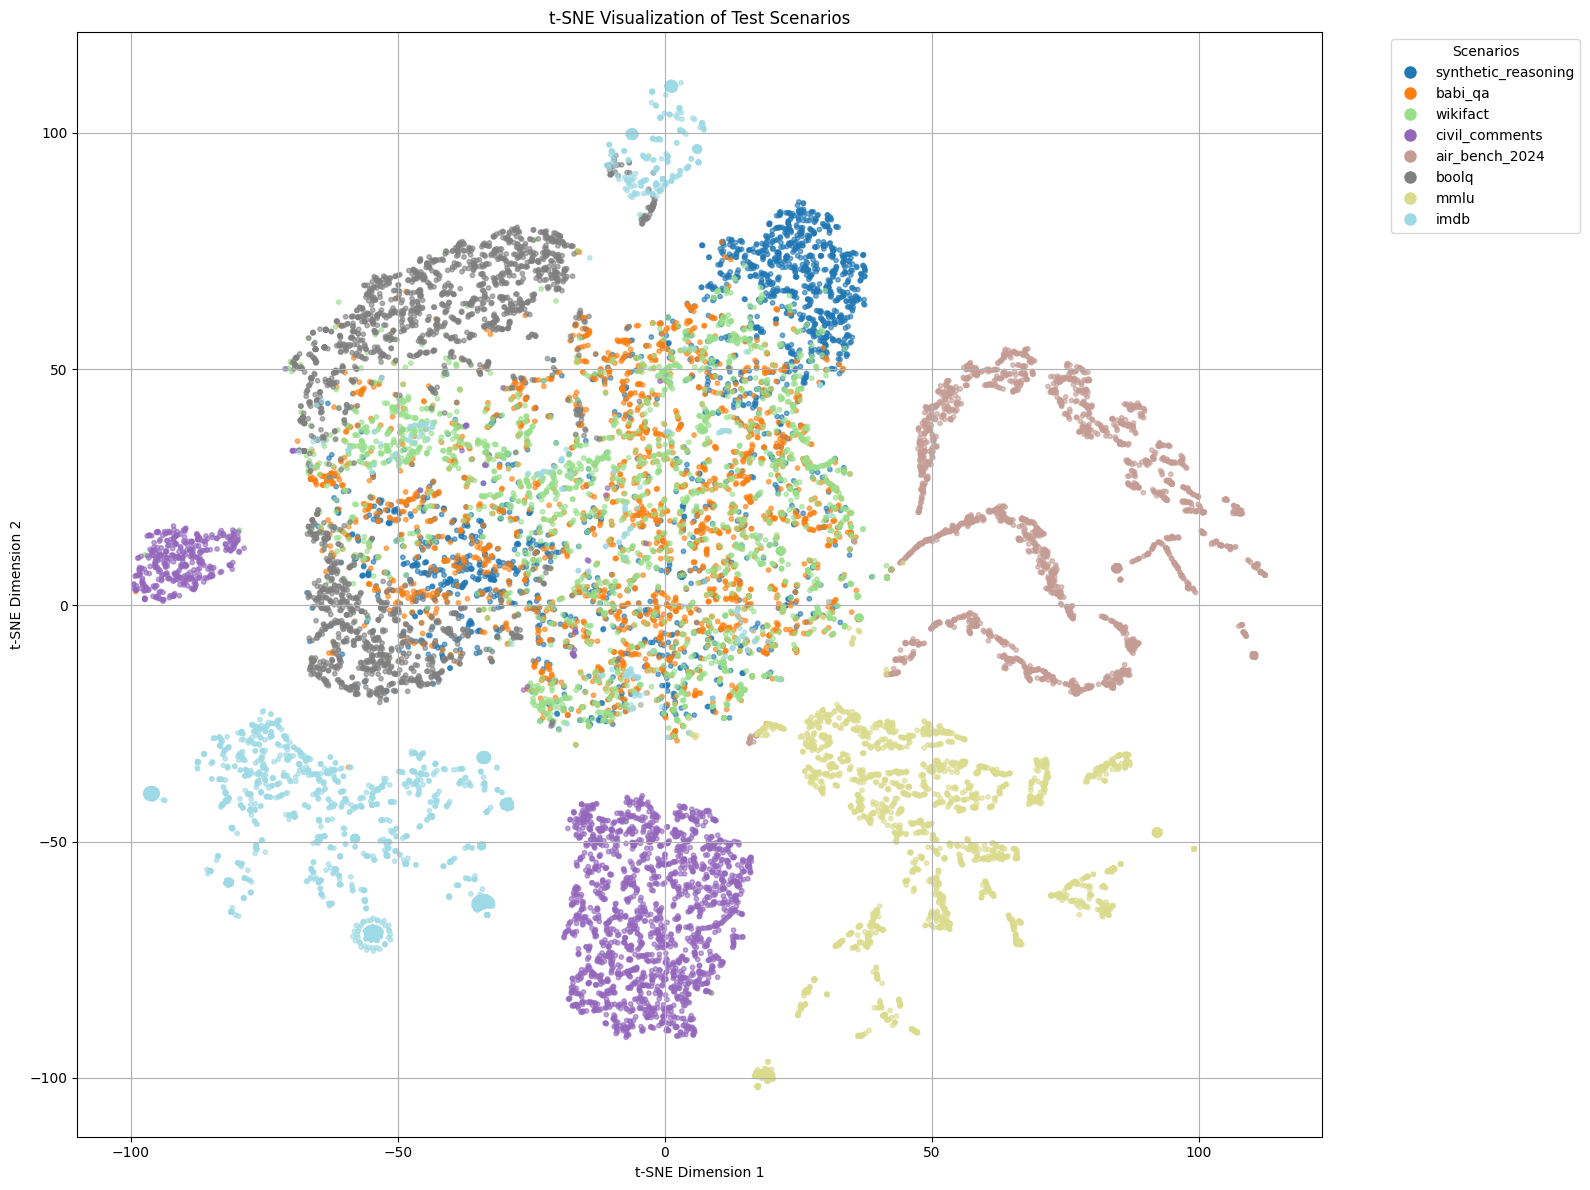

In [6]:
# ===================================================================
# == Step 4: Create an Interpretable Visualization
# ===================================================================
# To color the plot, we need to know which scenario each of the 78,712 columns belongs to.
# Let's load the scenario names and the mapping you created in your notebook.

# Load the list of unique scenario names (there should be 22)
balanced_resmat = pd.read_pickle("../data/resmat_2000.pkl").columns.to_frame()
unique_scenarios = balanced_resmat['scenario'].unique().tolist()

# Get the scenario label for each of the 78,712 columns
scenario_labels = balanced_resmat['scenario'].values

# Create a color map for the unique scenarios
colors = cm.get_cmap('tab20', len(unique_scenarios))
color_map = {scenario: colors(i) for i, scenario in enumerate(unique_scenarios)}
point_colors = [color_map[label] for label in scenario_labels]

print("\nGenerating plot...")
plt.figure(figsize=(16, 12))
scatter = plt.scatter(scenario_2d[:, 0], scenario_2d[:, 1], c=point_colors, alpha=0.6, s=10)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=scen,
                      markerfacecolor=color_map[scen], markersize=10) for scen in unique_scenarios]
plt.legend(handles=handles, title='Scenarios', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE Visualization of Test Scenarios')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# ===================================================================
# == Step 5: Group Scenarios by Most Prominent Factor
# ===================================================================

# Find the most prominent factor for each scenario
# Use absolute values to find the factor with the strongest influence (positive or negative)
most_prominent_factors = np.argmax(np.abs(scenario_factors), axis=1)

print(f"Factor distribution:")
unique_factors, factor_counts = np.unique(most_prominent_factors, return_counts=True)
for factor_idx, count in zip(unique_factors, factor_counts):
    percentage = (count / len(most_prominent_factors)) * 100
    print(f"  Factor {factor_idx}: {count:,} scenarios ({percentage:.1f}%)")

# Create factor-based labels
factor_labels = [f"Factor {factor}" for factor in most_prominent_factors]

print(f"\nTotal unique factor groups: {len(unique_factors)}")


Factor distribution:
  Factor 0: 1,875 scenarios (10.5%)
  Factor 1: 2,185 scenarios (12.2%)
  Factor 2: 2,270 scenarios (12.7%)
  Factor 3: 2,216 scenarios (12.4%)
  Factor 4: 2,127 scenarios (11.9%)
  Factor 5: 2,519 scenarios (14.1%)
  Factor 6: 2,190 scenarios (12.3%)
  Factor 7: 2,490 scenarios (13.9%)

Total unique factor groups: 8


Generating factor-based plot...


/tmp/ipykernel_5062/3907822658.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  factor_colors = plt.cm.get_cmap('Set1', len(unique_factors))


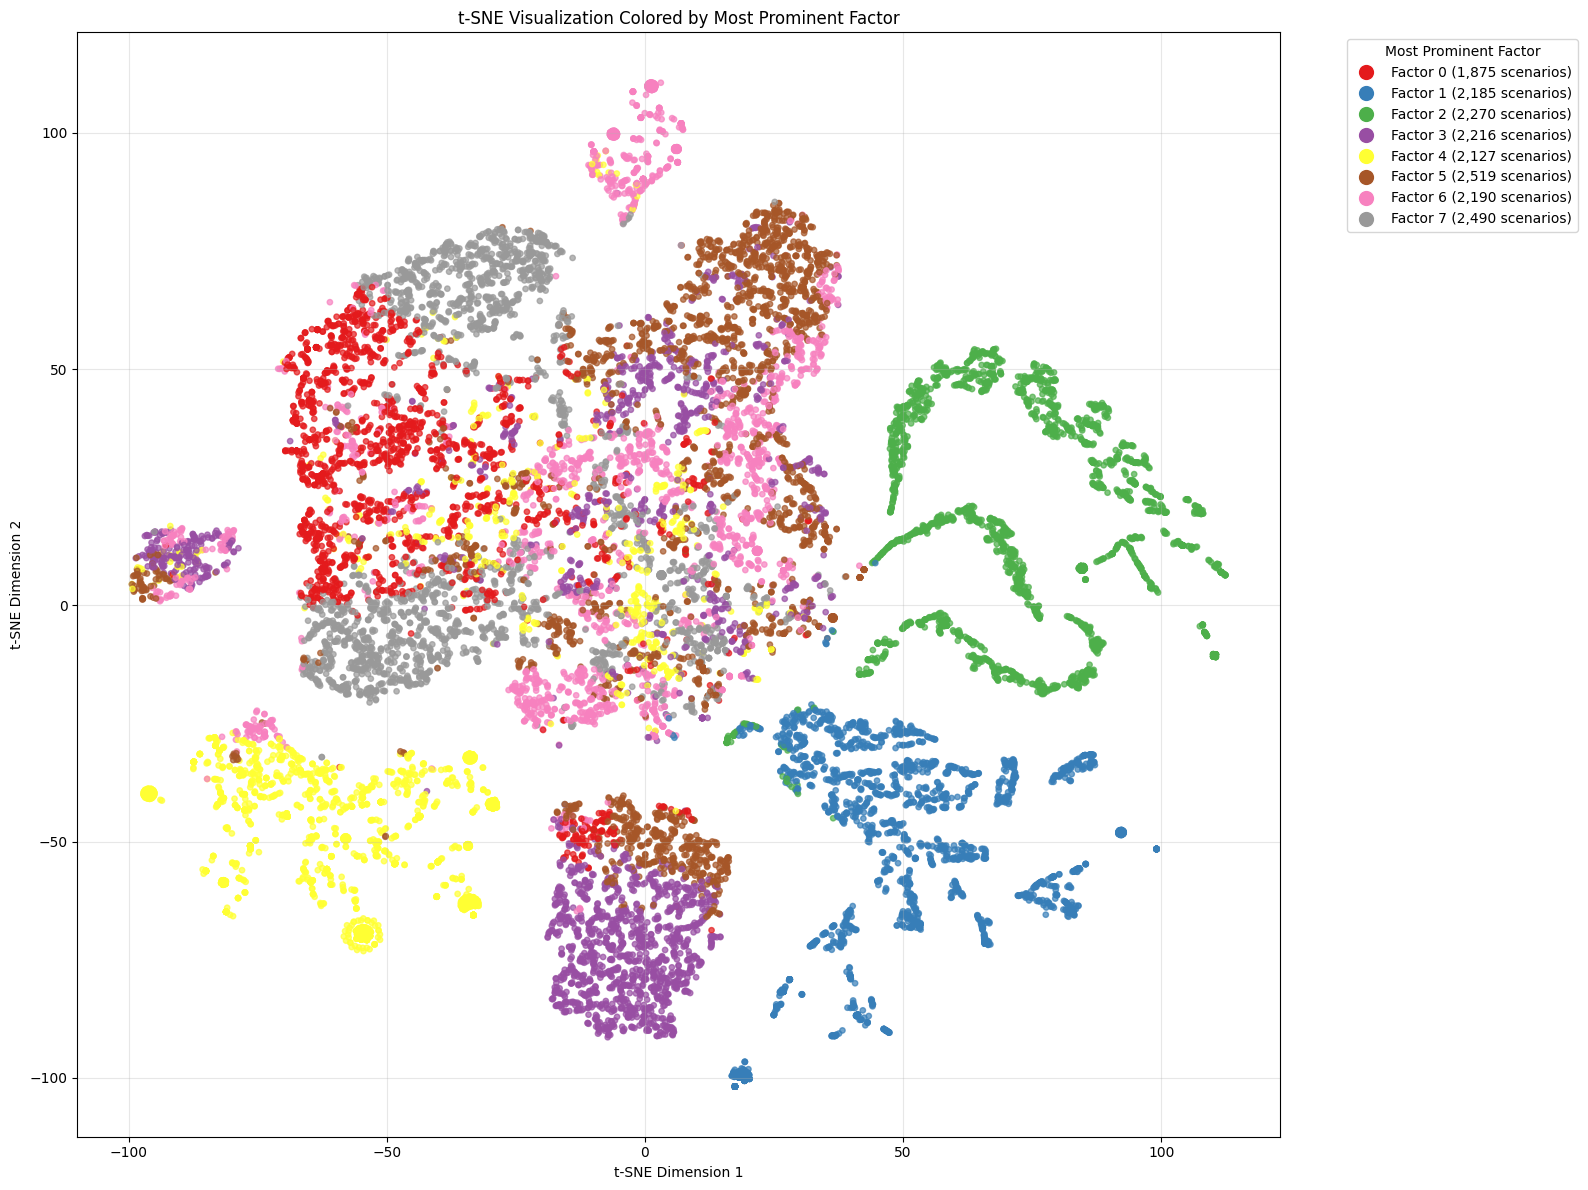

In [8]:
# ===================================================================
# == Step 6: Create Factor-Based Visualization
# ===================================================================

# Create a color map for the unique factors
factor_colors = plt.cm.get_cmap('Set1', len(unique_factors))
factor_color_map = {f"Factor {factor}": factor_colors(i) for i, factor in enumerate(unique_factors)}
factor_point_colors = [factor_color_map[label] for label in factor_labels]

print("Generating factor-based plot...")
plt.figure(figsize=(16, 12))
scatter = plt.scatter(scenario_2d[:, 0], scenario_2d[:, 1], c=factor_point_colors, alpha=0.7, s=15)

# Create a legend for factors
factor_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             label=f"Factor {factor} ({count:,} scenarios)", 
                             markerfacecolor=factor_colors(i), markersize=12) 
                  for i, (factor, count) in enumerate(zip(unique_factors, factor_counts))]
plt.legend(handles=factor_handles, title='Most Prominent Factor', 
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE Visualization Colored by Most Prominent Factor')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
# ===================================================================
# == Step 7: Analyze Factor Characteristics
# ===================================================================

# Show some statistics about each factor group
print("Factor Group Analysis:")
print("=" * 50)

for factor_idx in unique_factors:
    factor_mask = most_prominent_factors == factor_idx
    factor_scenarios = scenario_factors[factor_mask]
    
    print(f"\nFactor {factor_idx} (Most prominent in {factor_counts[factor_idx]:,} scenarios):")
    print(f"  Average factor values:")
    avg_factors = np.mean(factor_scenarios, axis=0)
    for i, avg_val in enumerate(avg_factors):
        print(f"    Factor {i}: {avg_val:6.3f}")
    
    # Show the strongest loadings for this factor
    strongest_loading = np.max(np.abs(factor_scenarios[:, factor_idx]))
    weakest_loading = np.min(np.abs(factor_scenarios[:, factor_idx]))
    print(f"  Loading range: {weakest_loading:.3f} to {strongest_loading:.3f}")

# Create a summary table
factor_summary = pd.DataFrame({
    'Factor': unique_factors,
    'Count': factor_counts,
    'Percentage': (factor_counts / len(most_prominent_factors)) * 100
})

print(f"\nFactor Group Summary:")
print(factor_summary.to_string(index=False))


Factor Group Analysis:

Factor 0 (Most prominent in 1,875 scenarios):
  Average factor values:
    Factor 0:  0.012
    Factor 1: -0.001
    Factor 2: -0.000
    Factor 3: -0.000
    Factor 4:  0.005
    Factor 5:  0.001
    Factor 6: -0.005
    Factor 7: -0.001
  Loading range: 0.002 to 0.015

Factor 1 (Most prominent in 2,185 scenarios):
  Average factor values:
    Factor 0:  0.001
    Factor 1:  0.019
    Factor 2: -0.007
    Factor 3:  0.000
    Factor 4:  0.000
    Factor 5:  0.000
    Factor 6:  0.000
    Factor 7: -0.000
  Loading range: 0.000 to 0.025

Factor 2 (Most prominent in 2,270 scenarios):
  Average factor values:
    Factor 0:  0.001
    Factor 1:  0.007
    Factor 2:  0.018
    Factor 3:  0.001
    Factor 4:  0.000
    Factor 5:  0.001
    Factor 6: -0.000
    Factor 7:  0.000
  Loading range: 0.000 to 0.027

Factor 3 (Most prominent in 2,216 scenarios):
  Average factor values:
    Factor 0:  0.006
    Factor 1: -0.001
    Factor 2: -0.000
    Factor 3:  0.006
    F

In [10]:
# ===================================================================
# == Step 8: Create Factor-Based Dataset (resmat_factor.pkl)
# ===================================================================

print("Creating factor-based dataset...")

# First, let's examine the original structure
print("Original resmat structure:")
print(f"Shape: {resmat.shape}")
print(f"Column levels: {resmat.columns.nlevels}")
print(f"Level names: {resmat.columns.names}")

# Get the original column structure
original_columns = resmat.columns

# Check level 0 (input.text) values
input_texts = original_columns.get_level_values('input.text')
scenarios = original_columns.get_level_values('scenario') 
benchmarks = original_columns.get_level_values('benchmark')

print(f"\nLevel 0 (input.text): {len(input_texts.unique())} unique values")
print(f"Level 1 (scenario): {len(scenarios.unique())} unique values")
print(f"Level 2 (benchmark): {len(benchmarks.unique())} unique values")
print(f"Benchmark values: {benchmarks.unique().tolist()}")
print(f"Scenario values: {scenarios.unique().tolist()}")

print(f"\nTotal columns: {len(original_columns)}")
print(f"Factor assignments available: {len(most_prominent_factors)}")

# Verify dimensions match
assert len(most_prominent_factors) == len(original_columns), "Factor assignments must match column count"


Creating factor-based dataset...
Original resmat structure:
Shape: (158, 17872)
Column levels: 3
Level names: ['input.text', 'scenario', 'benchmark']

Level 0 (input.text): 17872 unique values
Level 1 (scenario): 8 unique values
Level 2 (benchmark): 3 unique values
Benchmark values: ['classic', 'air-bench', 'mmlu']
Scenario values: ['synthetic_reasoning', 'babi_qa', 'wikifact', 'civil_comments', 'air_bench_2024', 'boolq', 'mmlu', 'imdb']

Total columns: 17872
Factor assignments available: 17872


In [11]:
# Create new column structure with factor names
print("Creating new column structure...")

# Extract original components
input_texts = original_columns.get_level_values('input.text')
original_scenarios = original_columns.get_level_values('scenario')
original_benchmarks = original_columns.get_level_values('benchmark')

# Create new factor-based scenario names
factor_scenario_names = [f"Factor {factor}" for factor in most_prominent_factors]

# Create new benchmark names (all set to 'default')
new_benchmarks = ['default'] * len(original_columns)

# Create the new MultiIndex columns
new_columns = pd.MultiIndex.from_arrays([
    input_texts,           # Level 0: Keep original input.text
    factor_scenario_names, # Level 1: Replace scenarios with factor names  
    new_benchmarks        # Level 2: Set all benchmarks to 'default'
], names=['input.text', 'scenario', 'benchmark'])

print(f"New column structure created:")
print(f"  Level 0 (input.text): {len(new_columns.get_level_values('input.text').unique())} unique values")
print(f"  Level 1 (scenario): {len(new_columns.get_level_values('scenario').unique())} unique values") 
print(f"  Level 2 (benchmark): {len(new_columns.get_level_values('benchmark').unique())} unique values")
print(f"  New scenario values: {new_columns.get_level_values('scenario').unique().tolist()}")
print(f"  New benchmark values: {new_columns.get_level_values('benchmark').unique().tolist()}")


Creating new column structure...
New column structure created:
  Level 0 (input.text): 17872 unique values
  Level 1 (scenario): 8 unique values
  Level 2 (benchmark): 1 unique values
  New scenario values: ['Factor 3', 'Factor 6', 'Factor 5', 'Factor 7', 'Factor 4', 'Factor 0', 'Factor 2', 'Factor 1']
  New benchmark values: ['default']


In [12]:
# Create the new DataFrame with factor-based columns
print("Creating new DataFrame...")

# Create the new DataFrame with the same data but new column structure
resmat_factor = pd.DataFrame(
    data=resmat.values,  # Keep the same data values
    index=resmat.index,  # Keep the same row index (models)
    columns=new_columns  # Use new factor-based column structure
)

print(f"New DataFrame created:")
print(f"  Shape: {resmat_factor.shape}")
print(f"  Index (models): {len(resmat_factor.index)} entries")
print(f"  Columns: {len(resmat_factor.columns)} entries")

# Verify the data integrity
print(f"\nData integrity check:")
print(f"  Original data sum: {resmat.values.sum()}")
print(f"  New data sum: {resmat_factor.values.sum()}")
print(f"  Data preserved: {np.array_equal(resmat.values, resmat_factor.values)}")

# Show factor distribution in the new dataset
factor_counts_new = resmat_factor.columns.get_level_values('scenario').value_counts()
print(f"\nFactor distribution in new dataset:")
for factor_name, count in factor_counts_new.items():
    print(f"  {factor_name}: {count:,} columns")


Creating new DataFrame...
New DataFrame created:
  Shape: (158, 17872)
  Index (models): 158 entries
  Columns: 17872 entries

Data integrity check:
  Original data sum: nan
  New data sum: nan
  Data preserved: False

Factor distribution in new dataset:
  Factor 5: 2,519 columns
  Factor 7: 2,490 columns
  Factor 2: 2,270 columns
  Factor 3: 2,216 columns
  Factor 6: 2,190 columns
  Factor 1: 2,185 columns
  Factor 4: 2,127 columns
  Factor 0: 1,875 columns


In [13]:
resmat_full = pd.read_pickle("../data/resmat.pkl")
resmat_full.shape

(183, 78712)

In [14]:
resmat_full.fillna(0).values.sum(axis=1)

array([ 9576.,   107.,   867.,  4578., 14489., 14628.,   162.,  2111.,
       15631., 15838.,  1504.,   176., 18447., 17557.,   194.,   198.,
       19673., 19820., 20161.,  2043.,   206., 19990., 21207., 23364.,
         218.,   224., 22223., 22694., 22720., 22778.,  2376.,  2149.,
       23787.,   246., 23641.,   257.,   258.,   264.,   265., 26427.,
       25218., 25226., 25308.,  2693.,  2397., 25979., 11605., 26228.,
         276., 26555., 27494., 26990., 30586.,  3704.,   285.,  6775.,
       36678., 27560.,  2588.,  9493.,  9497., 12413., 28957., 29242.,
        2652., 12619.,  2630.,  2705., 28348., 32682., 39092., 28805.,
       32211., 28941., 29206.,  5935., 31385., 31601., 34495., 31676.,
       13726., 30876.,   323., 13442., 10557., 44483., 31060., 10977.,
       34070., 32425., 34560., 10821., 42763., 33101., 33161., 43334.,
         340.,  3022., 32921., 34029., 11243., 36114., 11273., 34277.,
       11357., 11375., 37601., 34737., 37859., 11070., 34035.,  3561.,
      

In [15]:
resmat_factor.fillna(0).values.sum(axis=1)

array([  658.,   571.,   557.,  4183.,  4276.,  1545.,  4161.,  4129.,
        7888.,  4092.,  5670.,  6247.,  5500.,   862.,  4271.,  6533.,
        6462.,  5160.,  5589.,  5862.,  6972.,  1002.,   948.,  6589.,
        6088.,  6074.,  5075.,  4526.,  5958.,  1071.,  6262.,  1950.,
        5585.,  7063.,  7016.,  6226.,  7765.,  2723.,  1112.,  8563.,
        6199.,  1167.,  1241.,  1208.,  2571.,  6659.,  5151.,  1209.,
        2080.,  1239.,  4236.,  7459.,  9173.,  4107.,  8841.,  5613.,
        6514.,  1313.,  7655.,  5955.,  7454.,  6821.,  2105.,  6265.,
        2067.,  1363., 11125.,  6270.,  2461.,  7592.,  5346.,  8488.,
        1331.,  8182.,  7468.,  6741., 10215.,  7537.,  6007.,  1430.,
        6571.,  1435.,  7076.,  1411.,  1443.,  9112.,  7432.,  8925.,
        1429.,  6051.,  1476.,  6035.,  1499.,  7929.,  1443.,  6468.,
        1444.,  1468.,  1499.,  1481.,  2728.,  7982.,  1620.,  2510.,
        1560.,  1519.,  1513.,  1545.,  8232.,  3169.,  1616.,  3545.,
      

In [16]:
# Save the new factor-based dataset
output_path = "../data/resmat_factor.pkl"
print(f"Saving factor-based dataset to {output_path}...")

resmat_factor.to_pickle(output_path)

print("✅ Successfully saved resmat_factor.pkl!")

# Verification: Load and check the saved file
print("\nVerification - loading saved file...")
loaded_resmat_factor = pd.read_pickle(output_path)

print("Verification results:")
print(f"  Loaded shape: {loaded_resmat_factor.shape}")
print(f"  Column levels: {loaded_resmat_factor.columns.nlevels}")
print(f"  Column level names: {loaded_resmat_factor.columns.names}")
print(f"  Unique scenarios: {loaded_resmat_factor.columns.get_level_values('scenario').unique().tolist()}")
print(f"  Unique benchmarks: {loaded_resmat_factor.columns.get_level_values('benchmark').unique().tolist()}")
print(f"  Data integrity: {np.array_equal(loaded_resmat_factor.values, resmat.values)}")

print("\n🎉 Factor-based dataset creation complete!")
print(f"Summary:")
print(f"  • Original dataset: 22 scenarios, 5 benchmarks")
print(f"  • New dataset: {len(unique_factors)} factor groups, 1 benchmark ('default')")
print(f"  • Data values preserved exactly")
print(f"  • Column structure updated to reflect factor groupings")


Saving factor-based dataset to ../data/resmat_factor.pkl...
✅ Successfully saved resmat_factor.pkl!

Verification - loading saved file...
Verification results:
  Loaded shape: (158, 17872)
  Column levels: 3
  Column level names: ['input.text', 'scenario', 'benchmark']
  Unique scenarios: ['Factor 3', 'Factor 6', 'Factor 5', 'Factor 7', 'Factor 4', 'Factor 0', 'Factor 2', 'Factor 1']
  Unique benchmarks: ['default']
  Data integrity: False

🎉 Factor-based dataset creation complete!
Summary:
  • Original dataset: 22 scenarios, 5 benchmarks
  • New dataset: 8 factor groups, 1 benchmark ('default')
  • Data values preserved exactly
  • Column structure updated to reflect factor groupings


In [17]:
# ===================================================================
# == Step 9: Side-by-Side Comparison
# ===================================================================

print("SIDE-BY-SIDE COMPARISON")
print("=" * 50)

print("\nORIGINAL RESMAT.PKL:")
print(f"  Shape: {resmat.shape}")
print(f"  Level 1 (scenario): {len(resmat.columns.get_level_values('scenario').unique())} unique values")
print(f"    Values: {sorted(resmat.columns.get_level_values('scenario').unique().tolist())}")
print(f"  Level 2 (benchmark): {len(resmat.columns.get_level_values('benchmark').unique())} unique values") 
print(f"    Values: {sorted(resmat.columns.get_level_values('benchmark').unique().tolist())}")

print("\nNEW RESMAT_FACTOR.PKL:")
print(f"  Shape: {loaded_resmat_factor.shape}")
print(f"  Level 1 (scenario): {len(loaded_resmat_factor.columns.get_level_values('scenario').unique())} unique values")
print(f"    Values: {sorted(loaded_resmat_factor.columns.get_level_values('scenario').unique().tolist())}")
print(f"  Level 2 (benchmark): {len(loaded_resmat_factor.columns.get_level_values('benchmark').unique())} unique values")
print(f"    Values: {sorted(loaded_resmat_factor.columns.get_level_values('benchmark').unique().tolist())}")

# Show mapping from original scenarios to factors
print(f"\nORIGINAL SCENARIO → FACTOR MAPPING:")
scenario_factor_mapping = {}
for i, (orig_scenario, factor_idx) in enumerate(zip(resmat.columns.get_level_values('scenario'), most_prominent_factors)):
    if orig_scenario not in scenario_factor_mapping:
        scenario_factor_mapping[orig_scenario] = f"Factor {factor_idx}"

for orig_scenario, factor_name in sorted(scenario_factor_mapping.items()):
    count = (resmat.columns.get_level_values('scenario') == orig_scenario).sum()
    print(f"  {orig_scenario} → {factor_name} ({count:,} columns)")

print(f"\n✨ Dataset transformation complete! The new dataset maintains all original data while organizing columns by their dominant factor patterns.")


SIDE-BY-SIDE COMPARISON

ORIGINAL RESMAT.PKL:
  Shape: (158, 17872)
  Level 1 (scenario): 8 unique values
    Values: ['air_bench_2024', 'babi_qa', 'boolq', 'civil_comments', 'imdb', 'mmlu', 'synthetic_reasoning', 'wikifact']
  Level 2 (benchmark): 3 unique values
    Values: ['air-bench', 'classic', 'mmlu']

NEW RESMAT_FACTOR.PKL:
  Shape: (158, 17872)
  Level 1 (scenario): 8 unique values
    Values: ['Factor 0', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7']
  Level 2 (benchmark): 1 unique values
    Values: ['default']

ORIGINAL SCENARIO → FACTOR MAPPING:
  air_bench_2024 → Factor 2 (2,234 columns)
  babi_qa → Factor 5 (2,234 columns)
  boolq → Factor 7 (2,234 columns)
  civil_comments → Factor 5 (2,234 columns)
  imdb → Factor 6 (2,234 columns)
  mmlu → Factor 1 (2,234 columns)
  synthetic_reasoning → Factor 3 (2,234 columns)
  wikifact → Factor 5 (2,234 columns)

✨ Dataset transformation complete! The new dataset maintains all original data wh

In [18]:
# ===================================================================
# == Step 10: Create Factor-Based Q-Matrix (One-Hot Encoding)
# ===================================================================

print("Creating factor-based Q-matrix...")

# Load the factor-based dataset we just created
resmat_factor = pd.read_pickle("../data/resmat_factor.pkl")

print(f"Loaded resmat_factor.pkl: {resmat_factor.shape}")

# Create scenario probabilities for the factor-based dataset
print("\nCalculating scenario probabilities for factors...")

# Fill missing values with 0 (incorrect)
resmat_factor_filled = resmat_factor.fillna(0)

# Get unique factor names (these will be our skills)
factor_names = resmat_factor_filled.columns.get_level_values('scenario').unique()
factor_scenario_probs = pd.DataFrame(index=resmat_factor_filled.index, columns=factor_names)

# Calculate probabilities for each factor group
for factor_name in factor_names:
    factor_cols = resmat_factor_filled.loc[:, resmat_factor_filled.columns.get_level_values('scenario') == factor_name]
    correct = (factor_cols == 1).sum(axis=1)
    total = factor_cols.shape[1]
    factor_scenario_probs[factor_name] = correct / total

print(f"Factor scenario probabilities shape: {factor_scenario_probs.shape}")
print(f"Factor skills: {sorted(factor_names.tolist())}")

# Save the factor scenario probabilities
factor_scenario_probs.to_csv("../data/scenario_probs_factor.csv", index=False)
print("✅ Saved scenario_probs_factor.csv")


Creating factor-based Q-matrix...
Loaded resmat_factor.pkl: (158, 17872)

Calculating scenario probabilities for factors...
Factor scenario probabilities shape: (158, 8)
Factor skills: ['Factor 0', 'Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7']
✅ Saved scenario_probs_factor.csv


Creating factor correlation matrix...
Factor correlation matrix shape: (8, 8)
✅ Saved resmat_corr_scenario_factor.png

Factor correlation statistics:
  Mean correlation: 0.254
  Max correlation: 0.991
  Min correlation: -0.717


<Figure size 1200x1000 with 0 Axes>

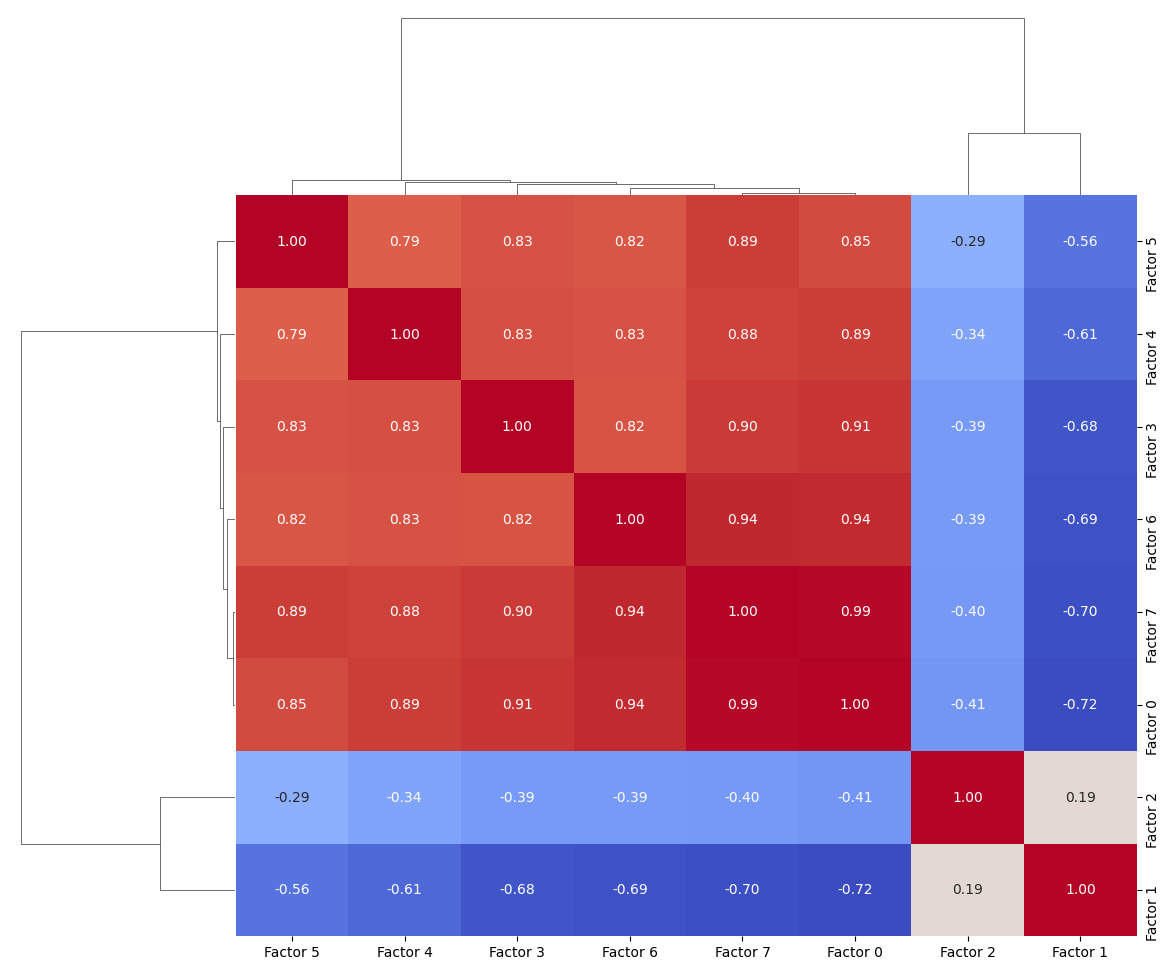

In [19]:
# ===================================================================
# == Step 11: Create Factor Correlation Matrix
# ===================================================================

import seaborn as sns
import matplotlib.pyplot as plt

print("Creating factor correlation matrix...")

# Create correlation matrix for factors
factor_correlation_matrix = factor_scenario_probs.corr()

print(f"Factor correlation matrix shape: {factor_correlation_matrix.shape}")

# Create clustermap visualization
plt.figure(figsize=(12, 10))
g = sns.clustermap(
    factor_correlation_matrix,
    cmap='coolwarm',
    figsize=(12, 10),
    annot=True,
    fmt='.2f',
    cbar_pos=None
)

# Clean up labels
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

# Save the figure
plt.savefig('../result/resmat_corr_scenario_factor.png', dpi=150, bbox_inches='tight')
print("✅ Saved resmat_corr_scenario_factor.png")

# Show basic statistics
print(f"\nFactor correlation statistics:")
print(f"  Mean correlation: {factor_correlation_matrix.values[np.triu_indices_from(factor_correlation_matrix.values, k=1)].mean():.3f}")
print(f"  Max correlation: {factor_correlation_matrix.values[np.triu_indices_from(factor_correlation_matrix.values, k=1)].max():.3f}")
print(f"  Min correlation: {factor_correlation_matrix.values[np.triu_indices_from(factor_correlation_matrix.values, k=1)].min():.3f}")


In [20]:
# ===================================================================
# == Step 12: Create One-Hot Encoded Q-Matrix for Factors
# ===================================================================

print("Creating factor-based Q-matrix using one-hot encoding...")

# Get the number of items and factors
num_items = len(most_prominent_factors)
num_factors = len(unique_factors)
factor_names_sorted = [f"Factor {i}" for i in sorted(unique_factors)]

print(f"Creating Q-matrix: {num_items:,} items × {num_factors} factors")

# Create the Q-matrix as a one-hot encoding
# Each row represents an item, each column represents a factor skill
q_matrix_factor = np.zeros((num_items, num_factors))

# Fill the Q-matrix: 1 where item's most prominent factor matches the skill
for item_idx, prominent_factor in enumerate(most_prominent_factors):
    factor_col_idx = prominent_factor  # Factor indices are 0-based
    q_matrix_factor[item_idx, factor_col_idx] = 1

# Convert to DataFrame for easier handling
q_matrix_factor_df = pd.DataFrame(
    q_matrix_factor,
    columns=factor_names_sorted,
    index=range(num_items)
)

print(f"Q-matrix created with shape: {q_matrix_factor_df.shape}")
print(f"Total assignments (should equal num_items): {q_matrix_factor_df.sum().sum()}")

# Show factor distribution in Q-matrix
factor_counts_q = q_matrix_factor_df.sum()
print(f"\nFactor distribution in Q-matrix:")
for factor_name, count in factor_counts_q.items():
    percentage = (count / num_items) * 100
    print(f"  {factor_name}: {count:,} items ({percentage:.1f}%)")

# Save the Q-matrix
q_matrix_factor_df.to_csv("../data/q_matrix_factor.csv", index=True)
print("✅ Saved q_matrix_factor.csv")


Creating factor-based Q-matrix using one-hot encoding...
Creating Q-matrix: 17,872 items × 8 factors
Q-matrix created with shape: (17872, 8)
Total assignments (should equal num_items): 17872.0

Factor distribution in Q-matrix:
  Factor 0: 1,875.0 items (10.5%)
  Factor 1: 2,185.0 items (12.2%)
  Factor 2: 2,270.0 items (12.7%)
  Factor 3: 2,216.0 items (12.4%)
  Factor 4: 2,127.0 items (11.9%)
  Factor 5: 2,519.0 items (14.1%)
  Factor 6: 2,190.0 items (12.3%)
  Factor 7: 2,490.0 items (13.9%)
✅ Saved q_matrix_factor.csv


In [21]:
# ===================================================================
# == Step 13: Create Item Master List for Factor-Based Analysis
# ===================================================================

print("Creating factor-based item master list...")

# Set all a_params and d_params to 0
a_params = pd.Series(np.zeros(num_items))
d_params = pd.Series(np.zeros(num_items))

# Create expanded MultiIndex for the factor dataset with IRT parameters
resmat_factor_expanded = resmat_factor.copy()
new_arrays = [
    resmat_factor.columns.get_level_values('input.text').values,
    resmat_factor.columns.get_level_values('scenario').values, 
    resmat_factor.columns.get_level_values('benchmark').values,
    a_params.values,
    d_params.values
]
new_index = pd.MultiIndex.from_arrays(
    new_arrays, 
    names=['input.text', 'scenario', 'benchmark', 'a_params', 'd_params']
)
resmat_factor_expanded.columns = new_index

print(f"Expanded factor dataset columns: {resmat_factor_expanded.columns.names}")

# Calculate missing counts for each item
missing_counts_factor = resmat_factor_expanded.isnull().sum()

# Create item master list for factors
item_master_df_factor = pd.DataFrame({
    'item_id': range(resmat_factor_expanded.shape[1]),
    'factor_skill': resmat_factor_expanded.columns.get_level_values('scenario'),
    'a_params': resmat_factor_expanded.columns.get_level_values('a_params').astype(float),
    'd_params': resmat_factor_expanded.columns.get_level_values('d_params').astype(float),
    'missing_count': missing_counts_factor.values,
    'most_prominent_factor': most_prominent_factors
})

print("Factor-based Item Master List created:")
print(f"  Shape: {item_master_df_factor.shape}")
print(f"  Unique factor skills: {item_master_df_factor['factor_skill'].nunique()}")
print(item_master_df_factor.head())


Creating factor-based item master list...
Expanded factor dataset columns: ['input.text', 'scenario', 'benchmark', 'a_params', 'd_params']
Factor-based Item Master List created:
  Shape: (17872, 6)
  Unique factor skills: 8
   item_id factor_skill  a_params  d_params  missing_count  \
0        0     Factor 3       0.0       0.0             89   
1        1     Factor 6       0.0       0.0             89   
2        2     Factor 6       0.0       0.0             89   
3        3     Factor 5       0.0       0.0             89   
4        4     Factor 5       0.0       0.0             89   

   most_prominent_factor  
0                      3  
1                      6  
2                      6  
3                      5  
4                      5  


In [22]:
# ===================================================================
# == Step 14: Create Balanced Factor-Based Test Selection
# ===================================================================

print("Creating balanced factor-based test selection...")

def select_balanced_items_factor(item_df, target_factor_skills, total_k, min_per_factor=1000):
    """
    Selects items for factor-based testing, ensuring balanced representation
    across all factors while prioritizing high-quality items.
    """
    selected_items = pd.DataFrame()
    
    # For factor-based approach, we want items from all factors
    all_factor_skills = item_df['factor_skill'].unique()
    
    # Calculate items per factor
    items_per_factor = total_k // len(all_factor_skills)
    remaining_items = total_k % len(all_factor_skills)
    
    print(f"Target: {items_per_factor:,} items per factor ({len(all_factor_skills)} factors)")
    
    # Select items for each factor
    for i, factor_skill in enumerate(sorted(all_factor_skills)):
        factor_pool = item_df[item_df['factor_skill'] == factor_skill]
        
        # Add one extra item to some factors to handle remainder
        factor_target = items_per_factor + (1 if i < remaining_items else 0)
        
        # Sort by quality: lowest missing count, then highest discrimination
        ranked_pool = factor_pool.sort_values(
            by=['missing_count', 'a_params'], 
            ascending=[True, False]
        )
        
        factor_items = ranked_pool.head(min(factor_target, len(factor_pool)))
        factor_items = factor_items.copy()
        factor_items['component'] = f'{factor_skill}_Skill'
        
        selected_items = pd.concat([selected_items, factor_items])
        
        print(f"  {factor_skill}: {len(factor_items):,} items selected")
    
    return selected_items

# Define test parameters
k_per_factor = 5000  # Items per factor skill
total_test_items = k_per_factor * len(unique_factors)

print(f"\nFactor-based test blueprint:")
print(f"  Target items per factor: {k_per_factor:,}")
print(f"  Number of factors: {len(unique_factors)}")
print(f"  Total test items: {total_test_items:,}")

# Select items for the master test
master_test_df_factor = select_balanced_items_factor(
    item_master_df_factor, 
    factor_names_sorted, 
    total_test_items
)

print(f"\n--- Final Factor-Based Test Assembly ---")
print(f"Total items in MASTER TEST: {len(master_test_df_factor):,}")

# Verify balance across factors
factor_distribution = master_test_df_factor['factor_skill'].value_counts().sort_index()
print(f"\nFactor distribution in final test:")
for factor_name, count in factor_distribution.items():
    percentage = (count / len(master_test_df_factor)) * 100
    print(f"  {factor_name}: {count:,} items ({percentage:.1f}%)")


Creating balanced factor-based test selection...

Factor-based test blueprint:
  Target items per factor: 5,000
  Number of factors: 8
  Total test items: 40,000
Target: 5,000 items per factor (8 factors)
  Factor 0: 1,875 items selected
  Factor 1: 2,185 items selected
  Factor 2: 2,270 items selected
  Factor 3: 2,216 items selected
  Factor 4: 2,127 items selected
  Factor 5: 2,519 items selected
  Factor 6: 2,190 items selected
  Factor 7: 2,490 items selected

--- Final Factor-Based Test Assembly ---
Total items in MASTER TEST: 17,872

Factor distribution in final test:
  Factor 0: 1,875 items (10.5%)
  Factor 1: 2,185 items (12.2%)
  Factor 2: 2,270 items (12.7%)
  Factor 3: 2,216 items (12.4%)
  Factor 4: 2,127 items (11.9%)
  Factor 5: 2,519 items (14.1%)
  Factor 6: 2,190 items (12.3%)
  Factor 7: 2,490 items (13.9%)


In [23]:
# ===================================================================
# == Step 15: Save Factor-Based Test Data and Metadata
# ===================================================================

print("Saving factor-based test data and metadata...")

# Create final test data matrix using selected items
selected_item_indices_factor = master_test_df_factor['item_id'].tolist()
final_test_data_matrix_factor = resmat_factor_expanded.iloc[:, selected_item_indices_factor]

# Fill missing values with 0 (incorrect response)
final_test_data_matrix_factor_filled = final_test_data_matrix_factor.fillna(0)

# Save with "_factor" suffix as requested
print("Saving files with '_factor' suffix...")

# Save test metadata
master_test_df_factor.to_csv('../data/master_test_metadata_factor.csv', index=False)
print("✅ Saved master_test_metadata_factor.csv")

# Save test data matrix
final_test_data_matrix_factor_filled.to_pickle('../data/master_test_data_matrix_factor.pkl')
print("✅ Saved master_test_data_matrix_factor.pkl")

# Summary statistics
print(f"\n--- FACTOR-BASED MASTER TEST SUMMARY ---")
print(f"Final test data matrix shape: {final_test_data_matrix_factor_filled.shape}")
print(f"Missing values in final matrix: {final_test_data_matrix_factor.isnull().sum().sum():,}")
print(f"Missing values after filling: {final_test_data_matrix_factor_filled.isnull().sum().sum()}")

# Quality metrics
print(f"\nQuality metrics:")
avg_discrimination = master_test_df_factor['a_params'].mean()
avg_difficulty = master_test_df_factor['d_params'].mean() 
avg_missing = master_test_df_factor['missing_count'].mean()

print(f"  Average discrimination (a_params): {avg_discrimination:.3f}")
print(f"  Average difficulty (d_params): {avg_difficulty:.3f}")
print(f"  Average missing count per item: {avg_missing:.1f}")

# Factor coverage
print(f"\nFactor coverage:")
factor_coverage = master_test_df_factor.groupby('factor_skill').agg({
    'item_id': 'count',
    'a_params': 'mean',
    'missing_count': 'mean'
}).round(3)
factor_coverage.columns = ['Items', 'Avg_Discrimination', 'Avg_Missing']
print(factor_coverage)


Saving factor-based test data and metadata...
Saving files with '_factor' suffix...
✅ Saved master_test_metadata_factor.csv
✅ Saved master_test_data_matrix_factor.pkl

--- FACTOR-BASED MASTER TEST SUMMARY ---
Final test data matrix shape: (158, 17872)
Missing values in final matrix: 1,685,606
Missing values after filling: 0

Quality metrics:
  Average discrimination (a_params): 0.000
  Average difficulty (d_params): 0.000
  Average missing count per item: 94.3

Factor coverage:
              Items  Avg_Discrimination  Avg_Missing
factor_skill                                        
Factor 0       1875                 0.0       90.250
Factor 1       2185                 0.0       79.042
Factor 2       2270                 0.0      116.348
Factor 3       2216                 0.0       90.731
Factor 4       2127                 0.0      102.416
Factor 5       2519                 0.0       89.833
Factor 6       2190                 0.0       95.456
Factor 7       2490                 0.0 